## Particle within radius or overlap calculations

In [22]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist


#plots
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns

#misc
import time
np.set_printoptions(suppress=True)

In [46]:
# set_number = 5
dir_save = '../../data/Sprints/AN/'
dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/'
df1 = pd.read_hdf(dir+'Run01/Run01.h5')
df2 = pd.read_hdf(dir+'Run02/Run02.h5')

In [10]:
dfx = pd.concat([df1,df2], ignore_index=True)

In [23]:
df = pd.read_hdf(dir+'Run05/Run05_InterpolatedX.hdf')

In [53]:
df.drop(index=df1.index[:6000], 
        axis=0, 
        inplace=True)

In [54]:
df.reset_index(inplace=True, drop=True) 

### Calculate Expected encounters

In [24]:
sync_time = df.master_time-df.master_time[0]
dt=df.master_time[1]-df.master_time[0]
df.insert(1,'sync_time',sync_time)

# storing the odor location in a numpy array to avoid reading pandas
source = np.array([[0,0]])
odor_position = np.array([[df.xsrc[i],df.ysrc[i]] for i in range (len(df.xsrc))]) 
distance_from_source = np.array([cdist(odor_position,source)]).flatten()

### Is Encountered odor particle within the Calculated particle radius?

The loop below computes locations of the eastwest and northsouth particles and compares with a radius (distance) to interpret if the encountered particle were close to calculated particle. The execution for the loop is 23.56 seconds for 59770 rows of data

For stationery wind sensor: The loop below takes in ith eastwest and subtracts the ith U and V elements to get the i-1 state, as the eastwest is summation of all the wind positions. 

[3 + 2 + 1] = [6]

hence ith _state = 6

_state = _state-3

_state = _state-2




In [25]:
#summation till Nth particle
eastwest = [np.sum(df.U[j:])*dt for j in range(0,len(df))]
northsouth = [np.sum(df.V[j:])*dt for j in range(0,len(df))]

In [26]:
nearest_from_streakline = []
distance_along_streakline = []

In [28]:
def compute_distance(streakline, odor_position):
    source = np.array([[0,0]])
    streakline = np.concatenate((streakline,source))
    distance = cdist(odor_position,streakline).flatten()   # cdist compares distance for all the points in both arrays
    nearest_from_streakline.append(np.min(distance))
    pos = np.where(distance == np.amin(distance))

    if (len(pos[0]) > 1):
        length=(np.sqrt(np.sum(np.diff(np.array(streakline[int(pos[0][0]):]), axis=0)**2, axis=1)))
    else:
        length=(np.sqrt(np.sum(np.diff(np.array(streakline[int(pos[0]):]), axis=0)**2, axis=1)))
        
    distance_along_streakline.append(np.sum(length))

In [37]:
len(eastwest)

6001

In [34]:
for i in range(len(eastwest)-1, 83496, -1):
    odor_pos = [odor_position[i]] 
    eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
    northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
    wind_pos = np.vstack([eastwest[-6000:],northsouth[-6000:]]).T   
    compute_distance(wind_pos,odor_pos)

In [36]:
for i in range(len(eastwest)-1, 6000, -1):
    odor_pos = [odor_position[i]] 
    eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
    northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
    wind_pos = np.vstack([eastwest[-6000:],northsouth[-6000:]]).T   
    compute_distance(wind_pos,odor_pos)

In [38]:
#for the section when only the length of the elements is equal to the window value
for i in range((len(eastwest))-1, -1, -1):
    
    odor_pos = [odor_position[i]]  
    if(i == 0):
        radius = np.zeros(1)
        wind_pos = np.array([[0,0]])
    else:
        eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
        northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
        wind_pos = np.vstack([eastwest,northsouth]).T   
        
    compute_distance(wind_pos,odor_pos)

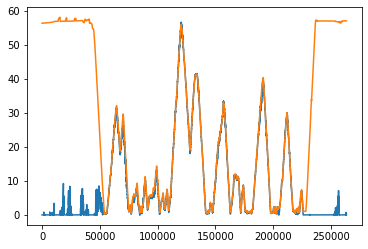

In [41]:
plt.plot(np.array(np.flip(distance_along_streakline)))
plt.plot(distance_from_source)

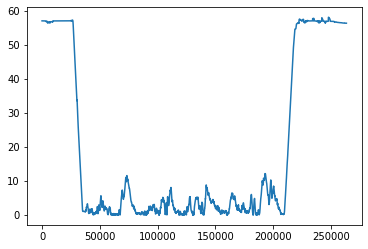

In [43]:
plt.plot(nearest_from_streakline)

In [44]:
## flip containers because above iteration is done in reverse order
df['mock'] = np.zeros(len(df))
distance_along_streakline = np.array(np.flip(distance_along_streakline)) 
nearest_from_streakline = np.array(np.flip(nearest_from_streakline)) 
# odor_presence = odor_presence[::-1]

## storing in the dataframe 
# df['odor_expected'] = odor_presence
df['distance_along_streakline'] =  distance_along_streakline
df['nearest_from_streakline'] = nearest_from_streakline
df['distance_from_source'] = distance_from_source

In [3]:
df1 = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run01/Run01_expected.h5') 
df2 = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run02/Run02_expected.h5') 

In [5]:
df = pd.concat([df1,df2[6000:]])
df.reset_index(inplace=True, drop=True)

In [45]:
df.to_hdf(dir+'Run05/Run05_expected.h5', key='df', mode='w')